# Project Stage III
### Francis Perez - Team 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import sys
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as smfem

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
#define the utilities folder for team functions
sys.path.insert(0,"../../util")
import teamsuperfileutilslib as tl

## Functions

In [2]:
def get_daily_from_team_df_from1stInfection(team_confirmed_or_death_dataframe,state,county_name=None,normByPop=False,popScaler=10000000.00):
    
    if (county_name is None):
        #create new dataframe by start
        data = team_confirmed_or_death_dataframe[team_confirmed_or_death_dataframe.apply(lambda x: (x["State"] == state), axis=1)].copy()
    else:
        #create new dataframe by start and by county name
        data = team_confirmed_or_death_dataframe[team_confirmed_or_death_dataframe.apply(lambda x: (x["State"] == state and x["County Name"] == county_name and \
             x["countyFIPS"] != 0), axis=1)].copy()
    
    #the popluation of the dataframe
    population = data["population"].sum()

    #keep only the date columns
    data = data[data.columns[5:]]
    
    #sum up the date columns
    data = pd.DataFrame(data[data.columns].sum(axis=0))
    
    #remove any indexes
    data.reset_index(inplace=True)
    
    #rename columns 
    data.columns= ["date","total"]
    
    #the the date column as a date type
    data["date"] = pd.to_datetime(data["date"])
        
    #get new cases or deaths
    data["total"] = data["total"].diff()
    
    #fill in any missing data
    data["total"] = data["total"].fillna(value=0)
    
    if normByPop:
        #normalize by population
        data["total"] = data.apply(lambda row: round((row["total"] / population) * popScaler,0), axis=1)

    data["days_since_start"] = -1

    indexOfFirstInfection = -1
    for index, row in data.iterrows():
        if row["total"] > 0:
            indexOfFirstInfection = index
            break
    
    data["days_since_start"] = data.apply(lambda row: row.name - indexOfFirstInfection if row.name >= indexOfFirstInfection else -1, axis=1)
    data = data[data.apply(lambda x: (x["days_since_start"] >= 0), axis=1)]
    return data

In [3]:
def plot_models_currentData(infection_df, data_title, linear_model, nonlinear_model):
    plt.figure(figsize=(15,5))
    
    #Plot the current/real data as scatter plot
    plt.scatter(infection_df["days_since_start"], infection_df["total"], label=data_title)

    #Plot the linear_model 
    plt.plot(infection_df["days_since_start"], round(linear_model.predict(infection_df["days_since_start"]),0), \
         label="Linear Model", c="darkred")
     
    #Plot the nonlinear_model
    plt.plot(infection_df["days_since_start"], round(nonlinear_model.predict(infection_df["days_since_start"]),0), \
         label="Non-Linear Model", c="darkgreen")

    #set plot information text
    plt.xlabel("Days Since First Infection")
    plt.ylabel("Total {}".format(data_title))

    plt.legend(loc="upper left")

    plt.title("{} & Linear Models".format(data_title))
    plt.show()

In [4]:
def predict_future(modelRm, days_to_predict_df, day_to_predict_Out=7):
    #Get the last day of the current data
    last_day = days_to_predict_df['days_since_start'].tail(1).iloc[0]

    #create list of days to perdict out by adding daysToPredict to the current days list
    days_to_perdict = np.array([day + last_day + 1  for day in range(day_to_predict_Out)])
    days_to_perdict = days_to_predict_df[['days_since_start']].copy().append(pd.DataFrame(days_to_perdict, columns=['days_since_start']),ignore_index=True)

    #Create new dataframe with the new predictions
    future_predicitions =  pd.DataFrame([round(fp,0) for fp in modelRm.predict(days_to_perdict)], columns=['total'])

    #Combine The Future precitions & the Future days into one dataframe with 2 columns
    future_predicitions = pd.concat([days_to_perdict.iloc[:].reset_index(drop=True), future_predicitions.reset_index(drop=True)], axis=1, ignore_index=False)
    return future_predicitions

In [5]:
def plot_model_currentData_future(infection_df, data_title, modelRm, predictions, hospital_bed_total = None, hospital_beds_used = None):
     plt.figure(figsize=(15,5))

     #Plot the current/real data as scatter plot
     plt.scatter(infection_df["days_since_start"], infection_df["total"], label=data_title )
     
     #Plot the predicitions for the next 7-days
     plt.plot(predictions["days_since_start"], predictions["total"], label="Prediction Non-Linear Model", c="Red")

     #Plot the model for the current data
     plt.plot(infection_df["days_since_start"], round(modelRm.predict(infection_df["days_since_start"]),0), \
         label="Non-Linear Model", c="darkgreen")

     if hospital_bed_total is not None and hospital_beds_used is not None:
        plt.hlines(y=hospital_bed_total, xmin=0, xmax=infection_df.shape[0], colors="m", linestyles="solid", label="Hospital Bed Staff Capacity")
        plt.hlines(y=hospital_beds_used, xmin=0, xmax=infection_df.shape[0], colors="m", linestyles="dotted", label="Hospital Bed Staff Current Useage")
  
     plt.xlabel("Days Since First Infection")
     plt.ylabel("Total {}".format(data_title))

     plt.legend(loc="upper left")

     plt.title("{}, Model, & Predictions".format(data_title))
     plt.show()

In [6]:
def print_state_county_predicition_and_plot(data_usa, state, county_name, labelTitle, normByPop=False, popScaler=1000000, hospital_bed_total = None, hospital_beds_used = None):
    #Get county data
    county_data = get_daily_from_team_df_from1stInfection(data_usa, state, county_name, normByPop, popScaler)
    
    #Create the non-linear model from confirmed cases # X = days_since_start & Y = total
    county_data_Nonliner_RM = smf.ols(formula='total ~ days_since_start + I(days_since_start ** 2.00) + I(days_since_start ** 3.00) + I(days_since_start ** 4.00)', data=county_data).fit()

    #Get the duplin county prediciton for the next 7 days
    county_Confirmed_prediction = predict_future(county_data_Nonliner_RM, county_data)
    
    plot_model_currentData_future(county_data, "{} {} {}".format(state, county_name, labelTitle), county_data_Nonliner_RM, county_Confirmed_prediction, hospital_bed_total, hospital_beds_used)

    print("Predicition For The Next 7-Days:")
    print(county_Confirmed_prediction.tail(7))

    if normByPop:
        print()
        print("*Normalize By Population Per {:,}".format(popScaler))

In [7]:
def State_Name_To_Abv(fullName):
    #List From source https://gist.github.com/rogerallen/1583593
    us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO',    'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA',
    'Guam': 'GU',    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM',    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands':'MP', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
    }
    if fullName in us_state_abbrev.keys():
        return us_state_abbrev[fullName]
    else:
        return fullName

## Import Team Super File

In [8]:
#read team super file
team_super_df =  pd.read_csv("..\..\..\data\Francis\superCOVID-19datafame.csv")

print(team_super_df.head(1))

   countyFIPS            County Name State  population  stateFIPS  \
0           0  Statewide Unallocated    AL           0          1   

   confirmed_1/22/20  confirmed_1/23/20  confirmed_1/24/20  confirmed_1/25/20  \
0                  0                  0                  0                  0   

   confirmed_1/26/20  ...  deaths_11/3/20  deaths_11/4/20  deaths_11/5/20  \
0                  0  ...               0               0               0   

   deaths_11/6/20  deaths_11/7/20  deaths_11/8/20  deaths_11/9/20  \
0               0               0               0               0   

   deaths_11/10/20  deaths_11/11/20  deaths_11/12/20  
0                0                0                0  

[1 rows x 597 columns]


## Import Team Super File With Employment Data

In [9]:
#read team super file with Employment data
team_super_df_With_Employment = pd.read_csv("..\..\..\data\Francis\Super_Employment_Merged_Task3.csv")

print(team_super_df_With_Employment.head(1))

   countyFIPS     County Name State  population  stateFIPS  confirmed_1/22/20  \
0        1001  Autauga County    AL       55869          1                  0   

   confirmed_1/23/20  confirmed_1/24/20  confirmed_1/25/20  confirmed_1/26/20  \
0                  0                  0                  0                  0   

   ...  employment_feb_gov_state_subtotal  employment_feb_priv_goods_subtotal  \
0  ...                              586.0                              2241.0   

   employment_feb_priv_services_subtotal  employment_feb_total  \
0                                 6211.0               11047.0   

   employment_mar_gov_fed_subtotal  employment_mar_gov_local_subtotal  \
0                             85.0                             1940.0   

   employment_mar_gov_state_subtotal  employment_mar_priv_goods_subtotal  \
0                              573.0                              2224.0   

   employment_mar_priv_services_subtotal  employment_mar_total  
0            

In [10]:
#Retrive the confirm cases and death cases for USA from the team super file
#Using the Team Utility function that was imported
confirmed_usa, deaths_usa = tl. get_confirmed_deaths_tuple_df_with_population(team_super_df)
print(confirmed_usa.head(5))
print(deaths_usa.head(5))

   countyFIPS            County Name State  stateFIPS  population  1/22/20  \
0           0  Statewide Unallocated    AL          1           0        0   
1        1001         Autauga County    AL          1       55869        0   
2        1003         Baldwin County    AL          1      223234        0   
3        1005         Barbour County    AL          1       24686        0   
4        1007            Bibb County    AL          1       22394        0   

   1/23/20  1/24/20  1/25/20  1/26/20  ...  11/3/20  11/4/20  11/5/20  \
0        0        0        0        0  ...        0        0        0   
1        0        0        0        0  ...     2197     2212     2230   
2        0        0        0        0  ...     6995     7061     7097   
3        0        0        0        0  ...     1074     1079     1080   
4        0        0        0        0  ...      890      897      907   

   11/6/20  11/7/20  11/8/20  11/9/20  11/10/20  11/11/20  11/12/20  
0        0        0   

## Starting the calculation For North Carolina
### Part 1.

### Calcuations for Confirmed Cases

In [11]:
NC_Confirmed = get_daily_from_team_df_from1stInfection(confirmed_usa,state="NC",county_name=None,normByPop=False)
print(NC_Confirmed.head(5))
print(NC_Confirmed.tail(5))

         date  total  days_since_start
41 2020-03-03    1.0                 0
42 2020-03-04    0.0                 1
43 2020-03-05    0.0                 2
44 2020-03-06    1.0                 3
45 2020-03-07    0.0                 4
          date   total  days_since_start
291 2020-11-08  1515.0               250
292 2020-11-09  2907.0               251
293 2020-11-10  3119.0               252
294 2020-11-11  2588.0               253
295 2020-11-12   781.0               254


### Creating Linear Regresson Model from data.

In [12]:
#Create the linear model from confirmed cases
# X = days_since_start & Y = total
NC_Confirm_liner_RM = smf.ols(formula='total ~ days_since_start', data=NC_Confirmed).fit()

print(NC_Confirm_liner_RM.summary())
print(NC_Confirm_liner_RM.params)

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     228.0
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           3.68e-37
Time:                        20:06:08   Log-Likelihood:                -2031.6
No. Observations:                 255   AIC:                             4067.
Df Residuals:                     253   BIC:                             4074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           38.6631     87.502  

### Create Non-Linear (Polynomial) Regresson Model from NC Confirmed data.

In [13]:
#Create the linear model from confirmed cases
# X = days_since_start & Y = total
NC_Confirm_Nonliner_RM = smf.ols(formula='total ~ days_since_start + I(days_since_start ** 2.00) + I(days_since_start ** 3.00) + I(days_since_start ** 4.00)', data=NC_Confirmed).fit()
print(NC_Confirm_Nonliner_RM.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     70.48
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           6.91e-40
Time:                        20:06:08   Log-Likelihood:                -2017.3
No. Observations:                 255   AIC:                             4045.
Df Residuals:                     250   BIC:                             4062.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### Plot both Linear & Non-Linear Model Of Confirmed Cases

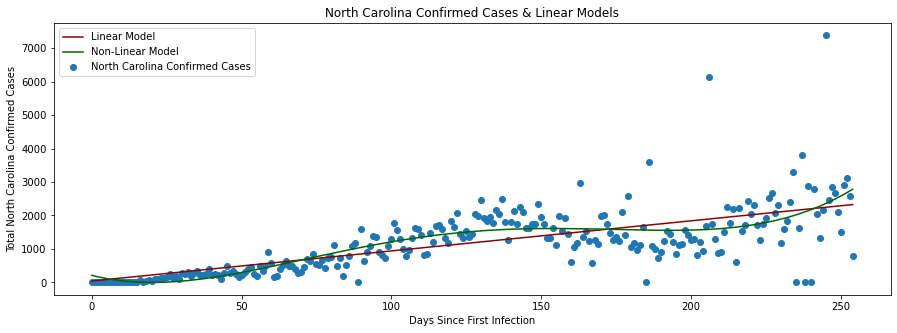

In [14]:
#Plot current data and both models
plot_models_currentData(NC_Confirmed, "North Carolina Confirmed Cases", NC_Confirm_liner_RM, NC_Confirm_Nonliner_RM)

### Validate Each Model using RMSE

In [15]:
#Calculate the RMSE for each model
NC_Confirmed_rmse_linear = smfem.rmse(x1=NC_Confirmed["total"], x2=NC_Confirm_liner_RM.predict(NC_Confirmed["days_since_start"]))
NC_Confirmed_rmse_none_linear = smfem.rmse(x1=NC_Confirmed["total"], x2=NC_Confirm_Nonliner_RM.predict(NC_Confirmed["days_since_start"]))

print("NC Confirmed Case - RMSE - Linear Model: {}\t|\tNon-Linear Model: {}".format(round(NC_Confirmed_rmse_linear, 2), round(NC_Confirmed_rmse_none_linear, 2)))

NC Confirmed Case - RMSE - Linear Model: 697.95	|	Non-Linear Model: 659.74


## Using the Non-Linear Model for making predictions as it has a lower RMSE Value

In [16]:
NC_Confirmed_prediction = predict_future(NC_Confirm_Nonliner_RM, NC_Confirmed)
print(NC_Confirmed_prediction.tail(7))

     days_since_start   total
255               255  2839.0
256               256  2896.0
257               257  2955.0
258               258  3016.0
259               259  3079.0
260               260  3143.0
261               261  3209.0


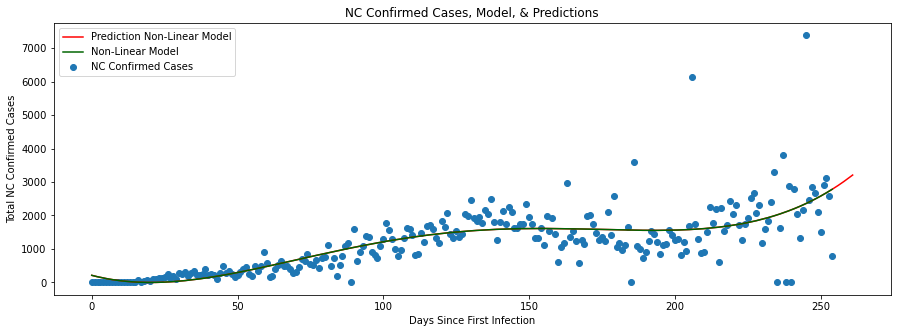

In [17]:
plot_model_currentData_future(NC_Confirmed, "NC Confirmed Cases", NC_Confirm_Nonliner_RM, NC_Confirmed_prediction)

### Calcuations for Deaths

In [18]:
NC_Deaths = get_daily_from_team_df_from1stInfection(deaths_usa,state="NC",county_name=None,normByPop=False)
print(NC_Confirmed.head(5))
print(NC_Confirmed.tail(5))

         date  total  days_since_start
41 2020-03-03    1.0                 0
42 2020-03-04    0.0                 1
43 2020-03-05    0.0                 2
44 2020-03-06    1.0                 3
45 2020-03-07    0.0                 4
          date   total  days_since_start
291 2020-11-08  1515.0               250
292 2020-11-09  2907.0               251
293 2020-11-10  3119.0               252
294 2020-11-11  2588.0               253
295 2020-11-12   781.0               254


### Creating Linear Regresson Model from deaths data.

In [19]:
#Create the linear model from confirmed cases
# X = days_since_start & Y = total
NC_Deaths_liner_RM = smf.ols(formula='total ~ days_since_start', data=NC_Deaths).fit()

print(NC_Deaths_liner_RM.summary())
print(NC_Deaths_liner_RM.params)

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     12.97
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           0.000387
Time:                        20:06:09   Log-Likelihood:                -1099.9
No. Observations:                 233   AIC:                             2204.
Df Residuals:                     231   BIC:                             2211.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            9.0650      3.562  

### Create Non-Linear (Polynomial) Regresson Model from NC Deaths data.

In [20]:
#Create the non-linear model from confirmed cases
# X = days_since_start & Y = total
NC_Deaths_Nonliner_RM = smf.ols(formula='total ~ days_since_start + I(days_since_start ** 2.00) + I(days_since_start ** 3.00) + I(days_since_start ** 4.00)', data=NC_Deaths).fit()
print(NC_Deaths_Nonliner_RM.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.328
Date:                Tue, 17 Nov 2020   Prob (F-statistic):             0.0113
Time:                        20:06:09   Log-Likelihood:                -1099.6
No. Observations:                 233   AIC:                             2209.
Df Residuals:                     228   BIC:                             2227.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### Plot both Linear & Non-Linear Model Of Deaths Cases

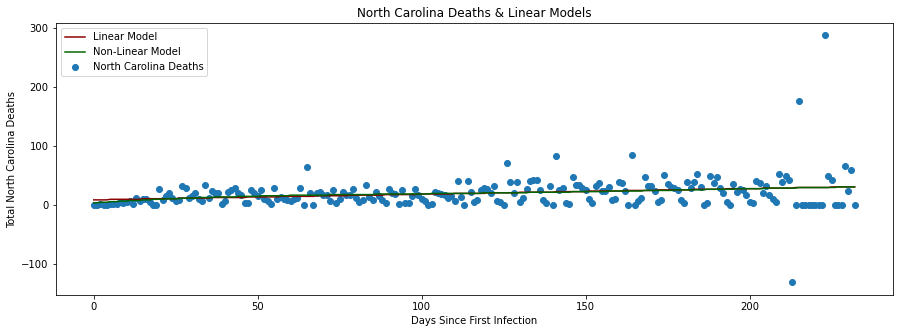

In [21]:
#Plot current data and both models
plot_models_currentData(NC_Deaths, "North Carolina Deaths", NC_Deaths_liner_RM, NC_Deaths_Nonliner_RM)

### Validate Each Model using RMSE for Deaths

In [22]:
#Calculate the RMSE for each model
NC_Deaths_rmse_linear = smfem.rmse(x1=NC_Deaths["total"], x2=NC_Deaths_liner_RM.predict(NC_Deaths["days_since_start"]))
NC_Deaths_rmse_none_linear = smfem.rmse(x1=NC_Deaths["total"], x2=NC_Deaths_Nonliner_RM.predict(NC_Deaths["days_since_start"]))

print("NC Confirmed Case - RMSE - Linear Model: {}\t|\tNon-Linear Model: {}".format(round(NC_Deaths_rmse_linear, 2), round(NC_Deaths_rmse_none_linear, 2)))

NC Confirmed Case - RMSE - Linear Model: 27.16	|	Non-Linear Model: 27.13


## Using the Linear Model for making predictions as the RMSE Values are very close and Linear has less variance.

In [23]:
NC_Deaths_prediction = predict_future(NC_Deaths_liner_RM, NC_Deaths)
print(NC_Deaths_prediction.tail(7))

     days_since_start  total
233               233   31.0
234               234   31.0
235               235   32.0
236               236   32.0
237               237   32.0
238               238   32.0
239               239   32.0


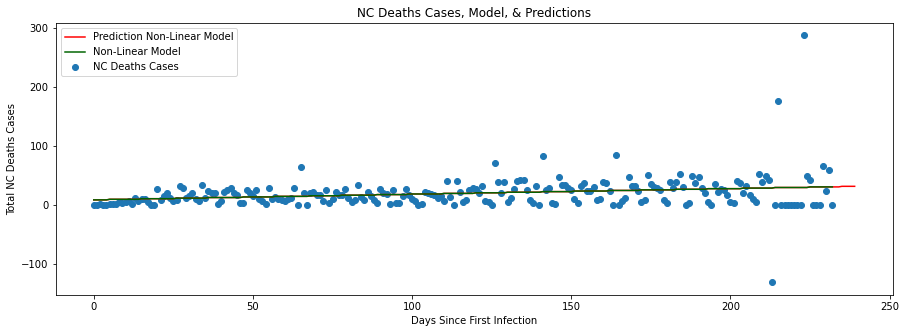

In [24]:
plot_model_currentData_future(NC_Deaths, "NC Deaths Cases", NC_Deaths_liner_RM, NC_Deaths_prediction)

# North Carolina Trends
* ## Confirmed Cases
     NC is predicted to see an increase in the number of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ## Deaths
     NC is predicted to see no change in the number of deaths, holding at 32 deaths, in the week of 11-13-2020 to 11-20-2020.

## End of Part 1.

# North Carolina Counties & Their Models 
## Part 2.

## Using These Top - 5 Most Infected Counties From Stage II Per Population 
* Duplin County
* Hertford County
* Jones County
* Robeson County
* Scotland County
### These Counties still hold the top spot for most Infected bases on current data by re-running Fperez_Task1.ipynb

## Calculate Duplin County

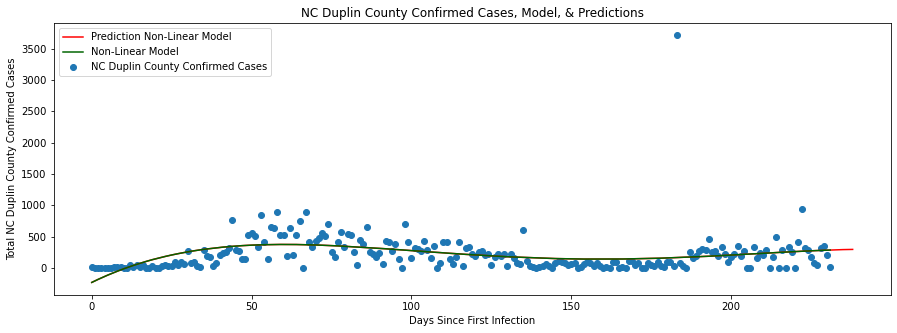

Predicition For The Next 7-Days:
     days_since_start  total
232               232  288.0
233               233  290.0
234               234  291.0
235               235  293.0
236               236  294.0
237               237  295.0
238               238  296.0

*Normalize By Population Per 1,000,000


In [25]:
# Duplin County Data Confirmed
print_state_county_predicition_and_plot(confirmed_usa, state="NC", county_name="Duplin County", labelTitle="Confirmed Cases", normByPop=True, popScaler=1000000)

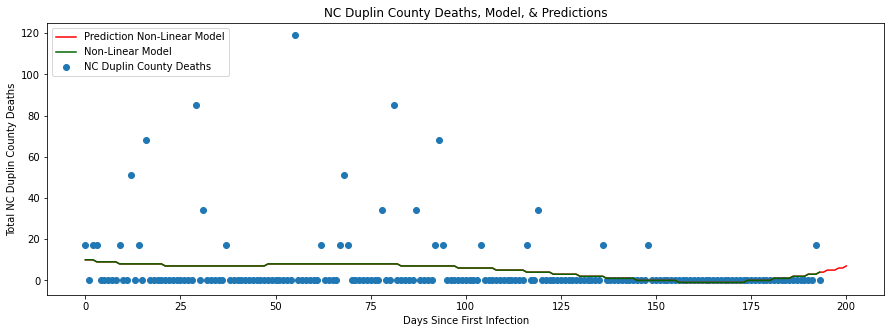

Predicition For The Next 7-Days:
     days_since_start  total
194               194    4.0
195               195    5.0
196               196    5.0
197               197    5.0
198               198    6.0
199               199    6.0
200               200    7.0

*Normalize By Population Per 1,000,000


In [26]:
# Duplin County Data Deaths
print_state_county_predicition_and_plot(deaths_usa, state="NC", county_name="Duplin County", labelTitle="Deaths", normByPop=True, popScaler=1000000)

## Calculate Hertford County

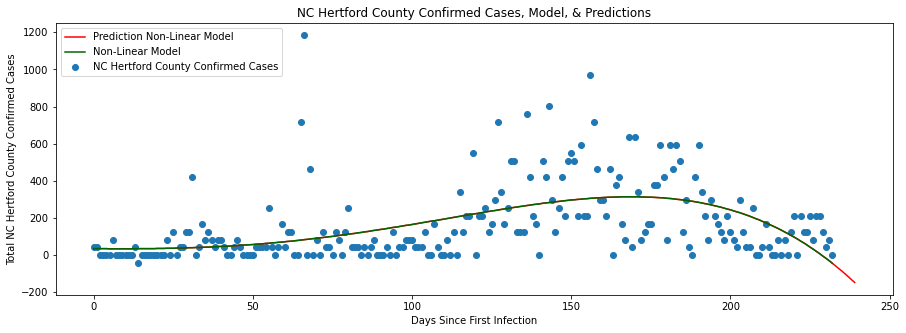

Predicition For The Next 7-Days:
     days_since_start  total
233               233  -58.0
234               234  -72.0
235               235  -86.0
236               236 -101.0
237               237 -116.0
238               238 -132.0
239               239 -147.0

*Normalize By Population Per 1,000,000


In [27]:
# Hertford County Data
print_state_county_predicition_and_plot(confirmed_usa, state="NC", county_name="Hertford County", labelTitle="Confirmed Cases", normByPop=True, popScaler=1000000)

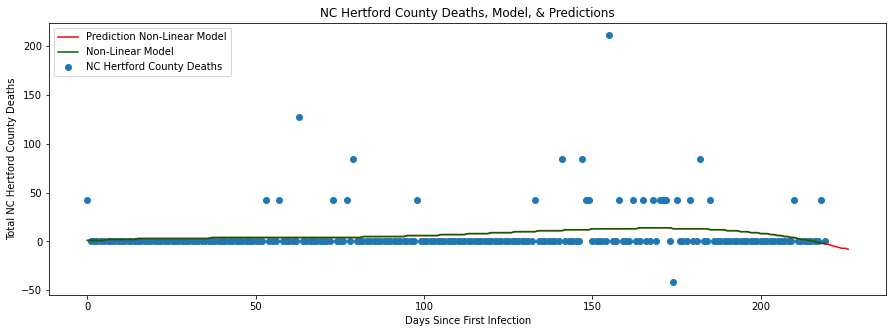

Predicition For The Next 7-Days:
     days_since_start  total
220               220   -3.0
221               221   -4.0
222               222   -5.0
223               223   -6.0
224               224   -7.0
225               225   -7.0
226               226   -8.0

*Normalize By Population Per 1,000,000


In [28]:
# Hertford County Data Deaths
print_state_county_predicition_and_plot(deaths_usa, state="NC", county_name="Hertford County", labelTitle="Deaths", normByPop=True, popScaler=1000000)

## Calculate Jones County

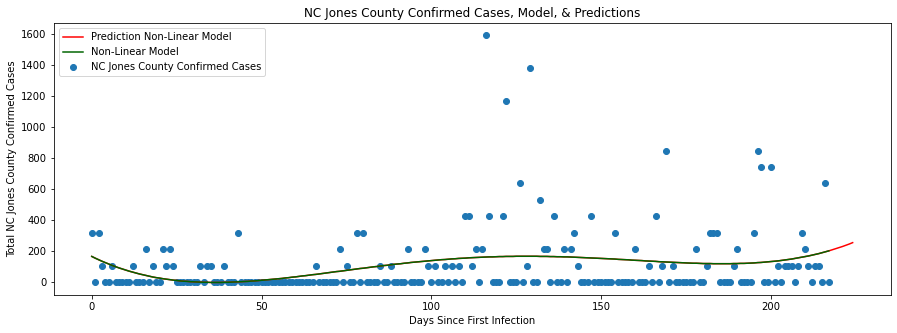

Predicition For The Next 7-Days:
     days_since_start  total
218               218  209.0
219               219  216.0
220               220  223.0
221               221  230.0
222               222  238.0
223               223  246.0
224               224  255.0

*Normalize By Population Per 1,000,000


In [29]:
# Jones County Data
print_state_county_predicition_and_plot(confirmed_usa, state="NC", county_name="Jones County", labelTitle="Confirmed Cases", normByPop=True, popScaler=1000000)

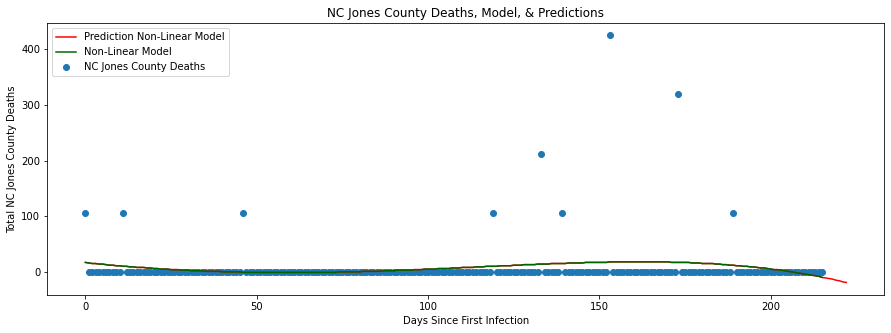

Predicition For The Next 7-Days:
     days_since_start  total
216               216  -11.0
217               217  -12.0
218               218  -13.0
219               219  -15.0
220               220  -16.0
221               221  -18.0
222               222  -19.0

*Normalize By Population Per 1,000,000


In [30]:
# Jones County Data Deaths
print_state_county_predicition_and_plot(deaths_usa, state="NC", county_name="Jones County", labelTitle="Deaths", normByPop=True, popScaler=1000000)

## Calculate Robeson County

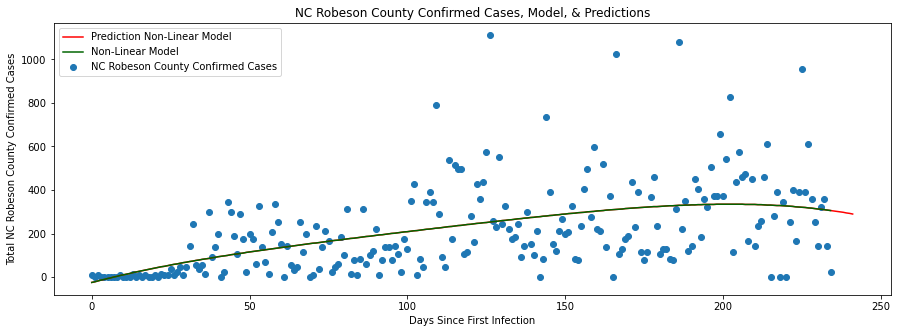

Predicition For The Next 7-Days:
     days_since_start  total
235               235  304.0
236               236  302.0
237               237  300.0
238               238  298.0
239               239  295.0
240               240  293.0
241               241  290.0

*Normalize By Population Per 1,000,000


In [31]:
# Robeson County Data
print_state_county_predicition_and_plot(confirmed_usa, state="NC", county_name="Robeson County", labelTitle="Confirmed Cases", normByPop=True, popScaler=1000000)

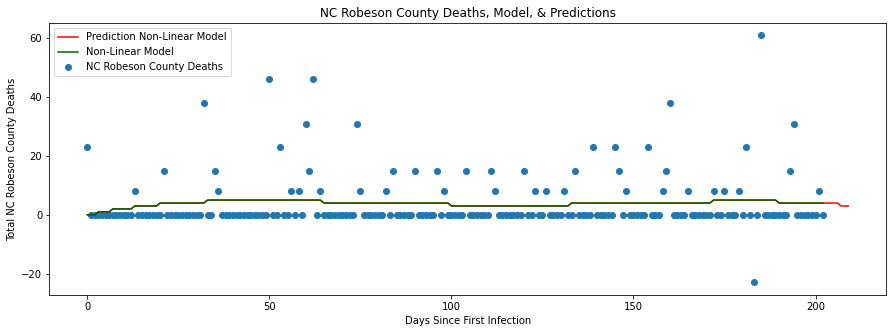

Predicition For The Next 7-Days:
     days_since_start  total
203               203    4.0
204               204    4.0
205               205    4.0
206               206    4.0
207               207    3.0
208               208    3.0
209               209    3.0

*Normalize By Population Per 1,000,000


In [32]:
print_state_county_predicition_and_plot(deaths_usa, state="NC", county_name="Robeson County", labelTitle="Deaths", normByPop=True, popScaler=1000000)

## Calculate Scotland County

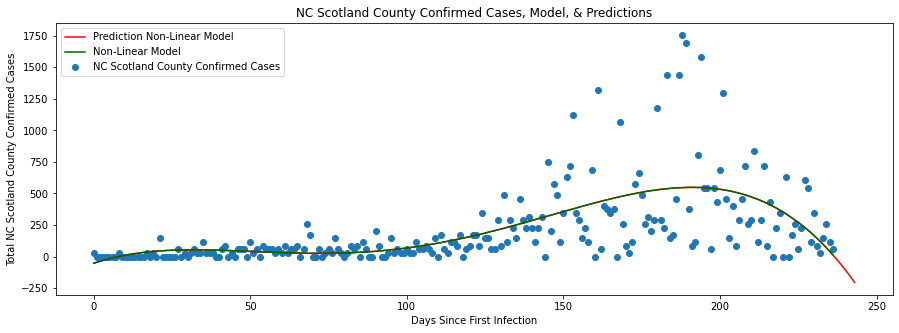

Predicition For The Next 7-Days:
     days_since_start  total
237               237  -14.0
238               238  -43.0
239               239  -73.0
240               240 -105.0
241               241 -137.0
242               242 -171.0
243               243 -205.0

*Normalize By Population Per 1,000,000


In [33]:
print_state_county_predicition_and_plot(confirmed_usa, state="NC", county_name="Scotland County", labelTitle="Confirmed Cases", normByPop=True, popScaler=1000000)

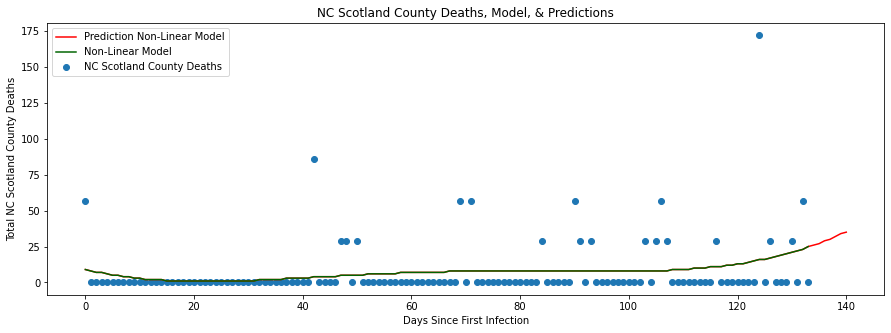

Predicition For The Next 7-Days:
     days_since_start  total
134               134   26.0
135               135   27.0
136               136   29.0
137               137   30.0
138               138   32.0
139               139   34.0
140               140   35.0

*Normalize By Population Per 1,000,000


In [34]:
print_state_county_predicition_and_plot(deaths_usa, state="NC", county_name="Scotland County", labelTitle="Deaths", normByPop=True, popScaler=1000000)

## Duplin County, NC  
* ### Confirmed Cases: 
Duplin is predicted to see no change, holding at around 17 per 1,000,000 population, of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Duplin is predicted to see a slight increase of new deaths in the week of 11-13-2020 to 11-20-2020.


## Hertford County, NC  
* ### Confirmed Cases: 
Hertford is predicted to see no change, holding at around 0 per 1,000,000 population, of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Hertford is predicted to see no change, holding at around 0 per 1,000,000 population, of new deaths in the week of 11-13-2020 to 11-20-2020.

## Jones County, NC  
* ### Confirmed Cases: 
Jones is predicted to see an increase of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Jones is predicted to see hold, holding at around 0 per 1,000,000 population, of new deaths in the week of 11-13-2020 to 11-20-2020.

## Robeson County, NC  
* ### Confirmed Cases: 
Robeson is predicted to see an increase of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Robeson is predicted to hold, holding at around 3 per 1,000,000 population, of new deaths in the week of 11-13-2020 to 11-20-2020.

## Scotland County, NC  
* ### Confirmed Cases: 
Scotland is predicted to hold, holding at around 0 per 1,000,000 population, see an increase of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Scotland is predicted to see a sharp increase of new deaths in the week of 11-13-2020 to 11-20-2020.

## End of Part 2.

## Part 3. 
## Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

### Load Hospital Beds Data File & Shape Data 
#### Using Staffed Bed because these that are available can take care of patients.

In [35]:
#read hospital data
hospital_bed_data = pd.read_csv("..\..\..\data\Francis\Definitive_Healthcare3A_USA_Hospital_Beds.csv")

#Remove Rehabilitation, as these are not medical
hospital_bed_data = hospital_bed_data[hospital_bed_data.apply(lambda x: (x["HOSPITAL_TYPE"] != "Rehabilitation Hospital"), axis=1)]

#Set any missing values to zero for Bed Utilization
hospital_bed_data["BED_UTILIZATION"] = hospital_bed_data["BED_UTILIZATION"].fillna(value=0)

#Clean FIPS column
hospital_bed_data["FIPS"] = hospital_bed_data["FIPS"].fillna(value=0)
hospital_bed_data["FIPS"] = hospital_bed_data["FIPS"].astype(int)

# change NUM_STAFFED_BEDS to int
hospital_bed_data["NUM_STAFFED_BEDS"] = hospital_bed_data["NUM_LICENSED_BEDS"].fillna(value=0)
hospital_bed_data["NUM_STAFFED_BEDS"] = hospital_bed_data["NUM_STAFFED_BEDS"].astype(int) 

#Remove unneeded columns
hospital_bed_data.drop(columns=["X", "Y", "OBJECTID", "HOSPITAL_NAME", "HOSPITAL_TYPE", "HQ_ADDRESS", "HQ_ADDRESS1", "HQ_CITY", "HQ_STATE", "HQ_ZIP_CODE", "STATE_FIPS","CNTY_FIPS", "NUM_LICENSED_BEDS", "NUM_ICU_BEDS", "ADULT_ICU_BEDS", "PEDI_ICU_BEDS", "Potential_Increase_In_Bed_Capac", "AVG_VENTILATOR_USAGE" ], inplace=True)

#Approximate Number Of Bed In Use from the  BED_UTILIZATION
hospital_bed_data["Beds_Used"] = round(hospital_bed_data["NUM_STAFFED_BEDS"] * hospital_bed_data["BED_UTILIZATION"],0)

#Round Bed used to whole number
hospital_bed_data["Beds_Used"] = hospital_bed_data["Beds_Used"].astype(int) 

hospital_bed_data = hospital_bed_data.sort_values(by='FIPS')

hospital_bed_data["STATE_NAME"] = hospital_bed_data["STATE_NAME"].apply(lambda x: State_Name_To_Abv(x))

#Group data by Counties and Sum up Total Staffed Bed and Beds Used
hospital_bed_data_By_County = hospital_bed_data.groupby(["FIPS"])["NUM_STAFFED_BEDS","Beds_Used"].apply(lambda x: x.sum()).reset_index()

hospital_bed_data_By_State = hospital_bed_data.groupby(["STATE_NAME"])["NUM_STAFFED_BEDS","Beds_Used"].apply(lambda x: x.sum()).reset_index()

print(hospital_bed_data_By_County.head(1))
print(hospital_bed_data_By_State.head(1))


   FIPS  NUM_STAFFED_BEDS  Beds_Used
0     0              2508       1299
  STATE_NAME  NUM_STAFFED_BEDS  Beds_Used
0         AK              1832        877


# Plot North Carolina Hospital Bed Data & Current Confirmed Cases & Model & Predictions

   STATE_NAME  NUM_STAFFED_BEDS  Beds_Used
27         NC             29052      17232


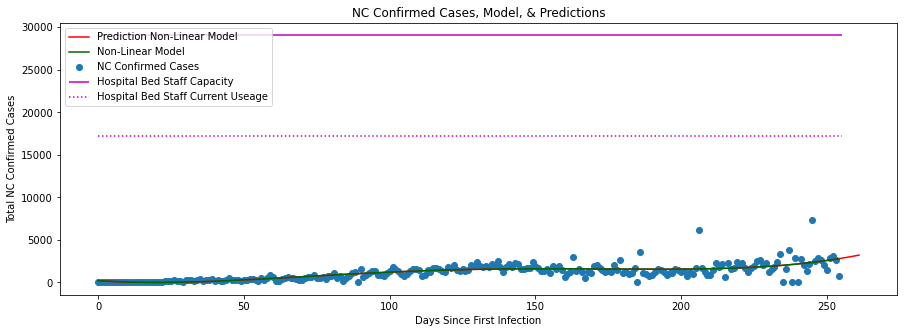

In [36]:
#Get Number of staffed beds & current Ulit
nc_total_hosp_beds = hospital_bed_data_By_State[ hospital_bed_data_By_State["STATE_NAME"] == "NC"]

print(nc_total_hosp_beds)

#Plot The data
plot_model_currentData_future(NC_Confirmed, "NC Confirmed Cases", NC_Confirm_Nonliner_RM, NC_Confirmed_prediction,nc_total_hosp_beds.iloc[0][1], nc_total_hosp_beds.iloc[0][2])

# North Carolina is not close to "Point of No Return", as it has had plenty of Hospital Bed Capacity

## States that might be close to "Point of No Return"

States that have seen Confirm Cases closed to equal or greater than Bed utilization.



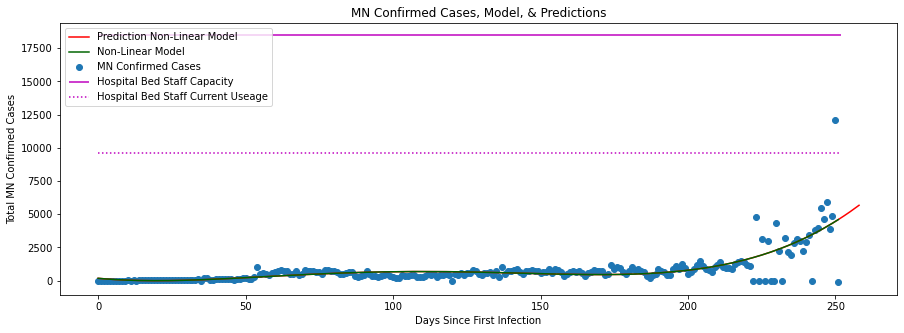

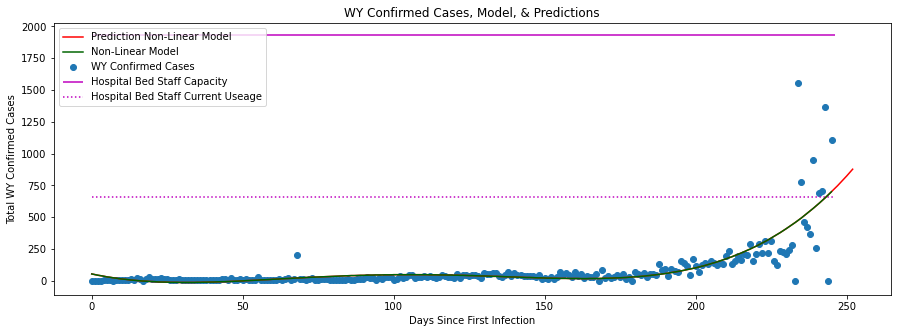

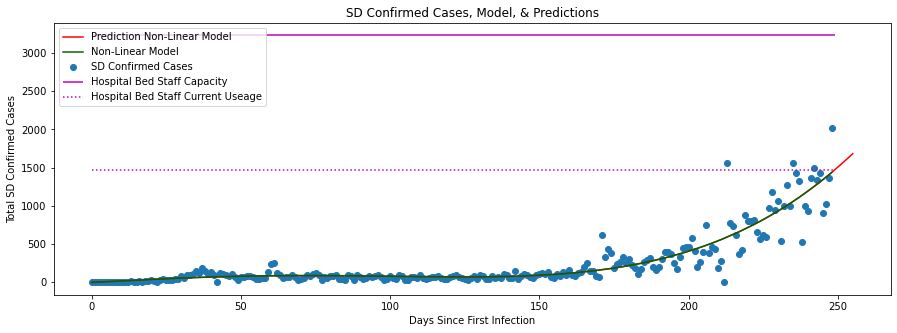

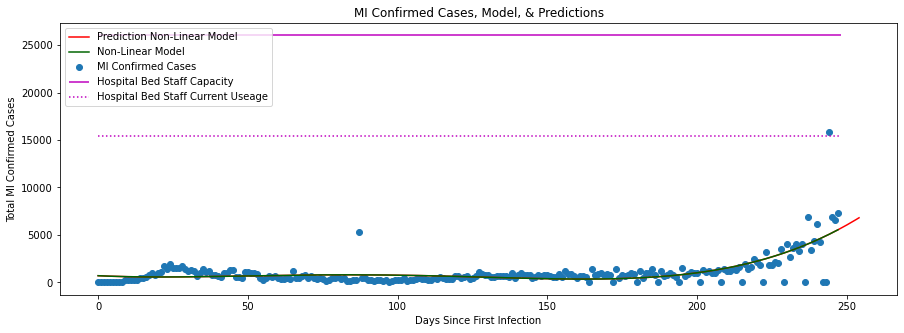

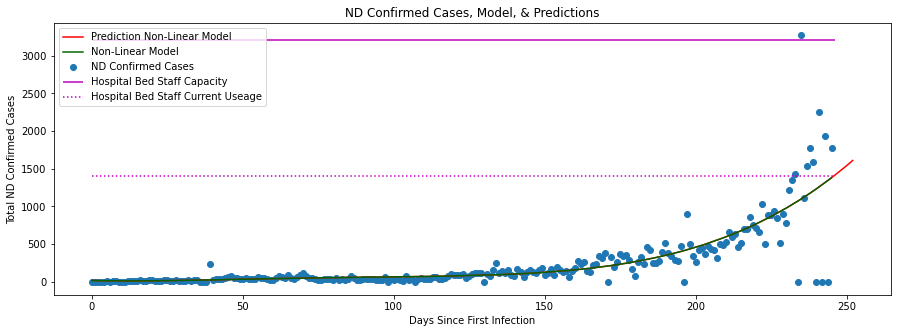

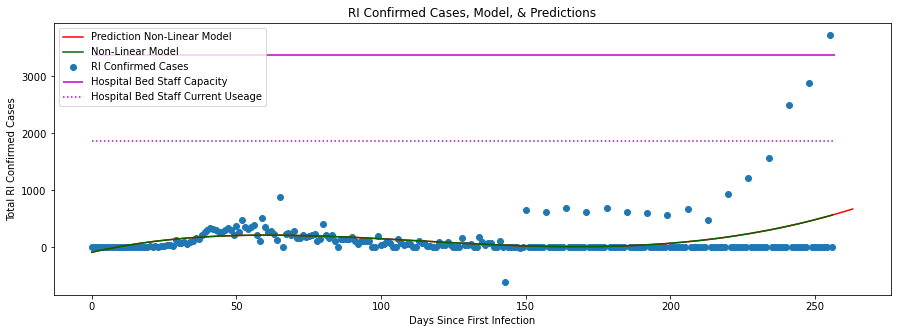

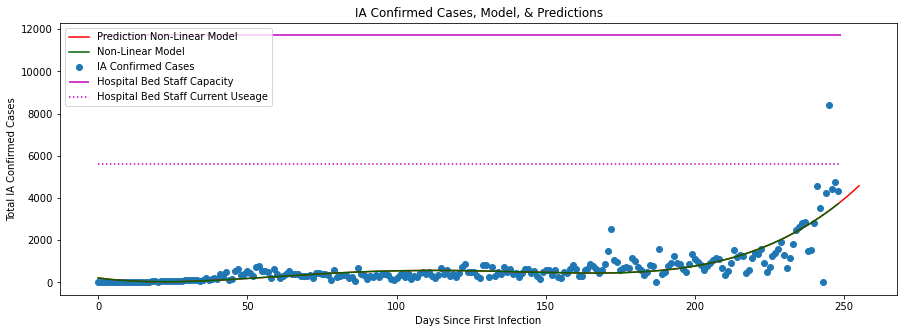

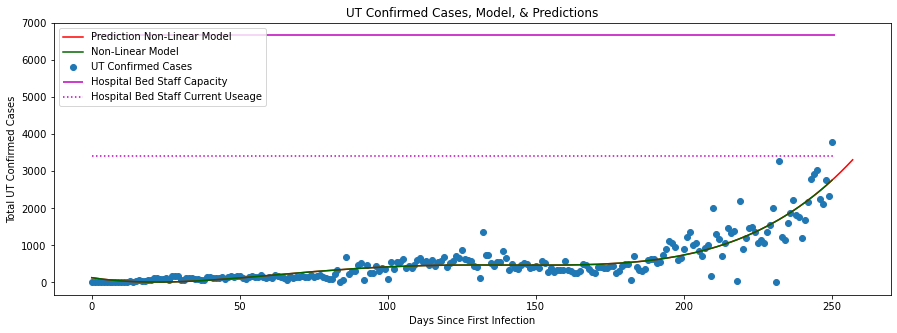

In [37]:
allStates = list(set(confirmed_usa["State"]))
print("States that have seen Confirm Cases closed to equal or greater than Bed utilization.")
print()

for state in allStates:
    #get hopsital bed data for the current state
    bedDataForState = hospital_bed_data_By_State[ hospital_bed_data_By_State["STATE_NAME"] == state]
    
    #get confimed cases for state
    confirmedTotalForState = get_daily_from_team_df_from1stInfection(confirmed_usa,state=state,county_name=None,normByPop=False)
    
    #get the max confirm case for all days
    max_confirmed_state = confirmedTotalForState["total"].max()
    
    #compute model for state
    stateNonliner_RM = smf.ols(formula='total ~ days_since_start + I(days_since_start ** 2.00) + I(days_since_start ** 3.00) + I(days_since_start ** 4.00)',                    data=confirmedTotalForState).fit()
    
    #get the 7-day prediciton for the state
    stateConfirmedprediction = predict_future(stateNonliner_RM, confirmedTotalForState)
    
    #get the max prediciton for all days
    max_prediction = stateConfirmedprediction["total"].max()

    #plot the data if Confirm Cases closed to equal or greater than Hospitial Bed utilization
    if (max_confirmed_state >= bedDataForState.iloc[0][2] or max_prediction >= bedDataForState.iloc[0][2]):
        #print("State: {}\t| Max Confirm Day Case: {}\t| Max Predicition: {} ".format(state,max_confirmed_state,max_prediction))
        plot_model_currentData_future(confirmedTotalForState, "{} Confirmed Cases".format(state), stateNonliner_RM, stateConfirmedprediction,bedDataForState.iloc[0][1],              bedDataForState.iloc[0][2])

## These State are close to being on the "Point of No Return". Due to them seeing confirmed cases on or above the "Current Useage" of hospital beds. When thse "Current Useage" is then added of the Covid Confirmed cases and the next 7-Days predictions this could be a serious problem for these states. 
* ### North Dakota- ND:
The trend predicted to continue increasing in the next 7-Days. This state has had a day where the confirmed cases have exceeded the number of beds for the state.
* ### Wyoming - WY: 
The trend predicted to continue increasing in the next 7-Days. 
* ### Iowa - IA: 
The trend predicted to continue increasing in the next 7-Days.
* ### Michigan - MI: 
The trend predicted to continue increasing in the next 7-Days
* ### South Dakota - SD: 
The trend predicted to continue increasing in the next 7-Days. 
* ### Utah - UT: 
The trend predicted to continue increasing in the next 7-Days. 
* ### Minnesota - MN: 
The trend predicted to continue increasing in the next 7-Days.
* ### Rhode Island - RI: 
The trend predicted to continue increasing in the next 7-Days. This state has had a day where the confirmed cases have exceeded the number of beds for the state.

## End Of Part 3

## Part 4 - Utilize decision tree, random forest, and ARIMA...

## Decision Tree Prediction

In [38]:
#Create numpy data from dataframe
x = NC_Confirmed[['days_since_start']].to_numpy()
y = NC_Confirmed['total'].astype(int).to_numpy()

last_day = NC_Confirmed['days_since_start'].tail(1).iloc[0]

#Create decision tree                                         
dec_Tree_nc_confirmed = DecisionTreeRegressor(max_depth=10)
dec_Tree_nc_confirmed.fit(x, y)

#Predict
nc_days_perdicted = np.array([day + last_day + 1  for day in range(7)])
nc_days_perdicted = NC_Confirmed[['days_since_start']].copy().append(pd.DataFrame(nc_days_perdicted, columns=['days_since_start']),ignore_index=True)
nc_days_perdicted["dec_tree_total"] = nc_days_perdicted.apply(lambda row: dec_Tree_nc_confirmed.predict([[row["days_since_start"]]])[0], axis=1)

## Random Forest Regressor Prediction

In [39]:
#Create Forest
rf_nc_confirmed = RandomForestRegressor(n_estimators=2)
rf_nc_confirmed.fit(x, y)

#Predict
rf_nc_days_perdicted = np.array([day + last_day + 1  for day in range(7)])
rf_nc_days_perdicted = NC_Confirmed[['days_since_start']].copy().append(pd.DataFrame(rf_nc_days_perdicted, columns=['days_since_start']),ignore_index=True)
rf_nc_days_perdicted["dec_tree_total"] = rf_nc_days_perdicted.apply(lambda row: rf_nc_confirmed.predict([[row["days_since_start"]]])[0], axis=1)

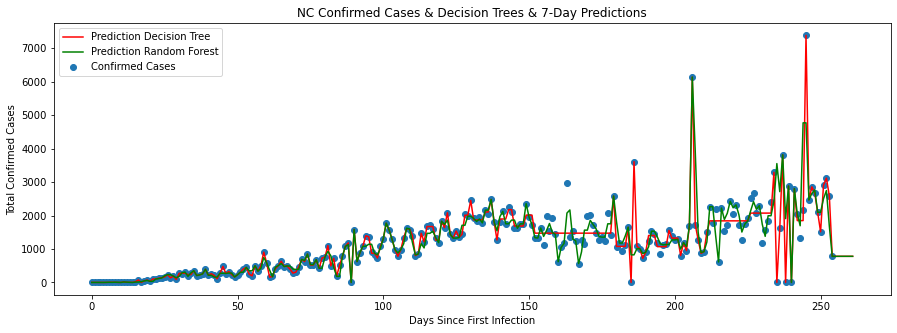

In [40]:
plt.figure(figsize=(15,5))

#Plot the current/real data as scatter plot
plt.scatter(NC_Confirmed["days_since_start"], NC_Confirmed["total"], label="Confirmed Cases" )

#Plot the Decision Tree for the next 7-days
plt.plot(nc_days_perdicted["days_since_start"],nc_days_perdicted["dec_tree_total"], label="Prediction Decision Tree", c="Red")

#Plot the Random Forest Tree for the next 7-days
plt.plot(rf_nc_days_perdicted["days_since_start"],rf_nc_days_perdicted["dec_tree_total"], label="Prediction Random Forest", c="green")

plt.xlabel("Days Since First Infection")
plt.legend(loc="upper left")
plt.xlabel("Days Since First Infection")
plt.ylabel("Total Confirmed Cases")
plt.legend(loc="upper left")
plt.title("NC Confirmed Cases & Decision Trees & 7-Day Predictions")
plt.show()

## Part 5 - Enrichment data to predict 

### Data Used From Enrichment File
* employment_mar_gov_fed_subtotal
* employment_mar_gov_local_subtotal
* employment_mar_gov_state_subtotal
* employment_mar_priv_goods_subtotal
* employment_mar_priv_services_subtotal

## Picking Forsyth County, As it has a good mix and the diferent types of employement data

## Confirmed Cases

## County Data Confirmed Cases

In [41]:
NC_Forsyth_County_Confirmed = get_daily_from_team_df_from1stInfection(confirmed_usa,state="NC",county_name="Forsyth County",normByPop=False)

last_day = NC_Forsyth_County_Confirmed['days_since_start'].tail(1).iloc[0]

NC_Forsyth_County_Emp = team_super_df_With_Employment[team_super_df_With_Employment.apply(lambda x: (x["State"] == "NC" and x["County Name"] == "Forsyth County" and x["countyFIPS"] != 0), axis=1)].copy()

#5 different variables from the enrichment data to predict the spread rate 
NC_Forsyth_County_Confirmed["fed"] = NC_Forsyth_County_Emp["employment_mar_gov_fed_subtotal"].iloc[0]
NC_Forsyth_County_Confirmed["local"] = NC_Forsyth_County_Emp["employment_mar_gov_local_subtotal"].iloc[0]
NC_Forsyth_County_Confirmed["state"] = NC_Forsyth_County_Emp["employment_mar_gov_state_subtotal"].iloc[0]
NC_Forsyth_County_Confirmed["goods"] = NC_Forsyth_County_Emp["employment_mar_priv_goods_subtotal"].iloc[0]
NC_Forsyth_County_Confirmed["services"] = NC_Forsyth_County_Emp["employment_mar_priv_services_subtotal"].iloc[0]

nc_forsyth_confirm_cols = ["days_since_start", "fed", "local","state","goods","services"]

#Create numpy data from dataframe
x_enrichment_confirmed = NC_Forsyth_County_Confirmed[nc_forsyth_confirm_cols].to_numpy()
y_enrichment_confirmed = NC_Forsyth_County_Confirmed["total"].astype(int).to_numpy()

## Decision Tree

In [42]:
#Create decision tree                                         
dec_Tree_nc_Forsyth_County_confirmed = DecisionTreeRegressor(max_depth=10)
dec_Tree_nc_Forsyth_County_confirmed.fit(x_enrichment_confirmed, y_enrichment_confirmed)

#Predict
nc_Forsyth_days_perdicted_confirmed = np.array([day + last_day + 1  for day in range(7)])

nc_Forsyth_days_perdicted_confirmed = NC_Forsyth_County_Confirmed[nc_forsyth_confirm_cols].copy().append(pd.DataFrame(nc_Forsyth_days_perdicted_confirmed, columns=['days_since_start']),ignore_index=True)

nc_Forsyth_days_perdicted_confirmed["fed"] = NC_Forsyth_County_Emp["employment_mar_gov_fed_subtotal"].iloc[0]
nc_Forsyth_days_perdicted_confirmed["local"] = NC_Forsyth_County_Emp["employment_mar_gov_local_subtotal"].iloc[0]
nc_Forsyth_days_perdicted_confirmed["state"] = NC_Forsyth_County_Emp["employment_mar_gov_state_subtotal"].iloc[0]
nc_Forsyth_days_perdicted_confirmed["goods"] = NC_Forsyth_County_Emp["employment_mar_priv_goods_subtotal"].iloc[0]
nc_Forsyth_days_perdicted_confirmed["services"] = NC_Forsyth_County_Emp["employment_mar_priv_services_subtotal"].iloc[0]

nc_Forsyth_days_perdicted_confirmed["dec_tree_total"] = nc_Forsyth_days_perdicted_confirmed.apply(lambda row: dec_Tree_nc_Forsyth_County_confirmed.predict([[row["days_since_start"], row["fed"], row["local"], row["state"], row["goods"], row["services"]]])[0], axis=1)

## Random Forest

In [43]:
#Create decision tree                                         
rf_nc_Forsyth_County_confirmed = RandomForestRegressor(n_estimators=2)
rf_nc_Forsyth_County_confirmed.fit(x_enrichment_confirmed, y_enrichment_confirmed)

#Predict
rf_nc_Forsyth_days_perdicted_confirmed = np.array([day + last_day + 1  for day in range(7)])

rf_nc_Forsyth_days_perdicted_confirmed = NC_Forsyth_County_Confirmed[nc_forsyth_confirm_cols].copy().append(pd.DataFrame(rf_nc_Forsyth_days_perdicted_confirmed, columns=['days_since_start']),ignore_index=True)

rf_nc_Forsyth_days_perdicted_confirmed["fed"] = NC_Forsyth_County_Emp["employment_mar_gov_fed_subtotal"].iloc[0]
rf_nc_Forsyth_days_perdicted_confirmed["local"] = NC_Forsyth_County_Emp["employment_mar_gov_local_subtotal"].iloc[0]
rf_nc_Forsyth_days_perdicted_confirmed["state"] = NC_Forsyth_County_Emp["employment_mar_gov_state_subtotal"].iloc[0]
rf_nc_Forsyth_days_perdicted_confirmed["goods"] = NC_Forsyth_County_Emp["employment_mar_priv_goods_subtotal"].iloc[0]
rf_nc_Forsyth_days_perdicted_confirmed["services"] = NC_Forsyth_County_Emp["employment_mar_priv_services_subtotal"].iloc[0]

rf_nc_Forsyth_days_perdicted_confirmed["rf_total"] = nc_Forsyth_days_perdicted_confirmed.apply(lambda row: rf_nc_Forsyth_County_confirmed.predict([[row["days_since_start"], row["fed"], row["local"], row["state"], row["goods"], row["services"]]])[0], axis=1)

## Plot the Confirmed Cases

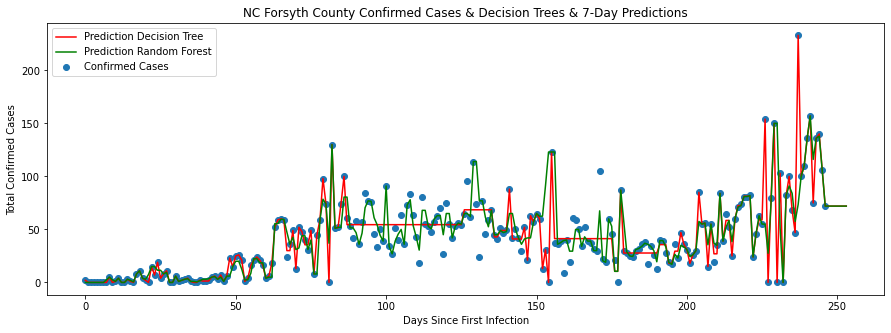

In [44]:
plt.figure(figsize=(15,5))

#Plot the current/real data as scatter plot
plt.scatter(NC_Forsyth_County_Confirmed["days_since_start"], NC_Forsyth_County_Confirmed["total"], label="Confirmed Cases" )

#Plot the Decision Tree for the next 7-days
plt.plot(nc_Forsyth_days_perdicted_confirmed["days_since_start"],nc_Forsyth_days_perdicted_confirmed["dec_tree_total"], label="Prediction Decision Tree", c="Red")

#Plot the Random Forest Tree for the next 7-days
plt.plot(rf_nc_Forsyth_days_perdicted_confirmed["days_since_start"], rf_nc_Forsyth_days_perdicted_confirmed["rf_total"], label="Prediction Random Forest", c="green")

plt.xlabel("Days Since First Infection")
plt.legend(loc="upper left")
plt.xlabel("Days Since First Infection")
plt.ylabel("Total Confirmed Cases")
plt.legend(loc="upper left")
plt.title("NC Forsyth County Confirmed Cases & Decision Trees & 7-Day Predictions")
plt.show()

## County Data Deaths

In [45]:
NC_Forsyth_County_deaths = get_daily_from_team_df_from1stInfection(deaths_usa,state="NC",county_name="Forsyth County",normByPop=False)

last_day = NC_Forsyth_County_deaths['days_since_start'].tail(1).iloc[0]

NC_Forsyth_County_Emp = team_super_df_With_Employment[team_super_df_With_Employment.apply(lambda x: (x["State"] == "NC" and x["County Name"] == "Forsyth County" and x["countyFIPS"] != 0), axis=1)].copy()

#5 different variables from the enrichment data to predict the spread rate 
NC_Forsyth_County_deaths["fed"] = NC_Forsyth_County_Emp["employment_mar_gov_fed_subtotal"].iloc[0]
NC_Forsyth_County_deaths["local"] = NC_Forsyth_County_Emp["employment_mar_gov_local_subtotal"].iloc[0]
NC_Forsyth_County_deaths["state"] = NC_Forsyth_County_Emp["employment_mar_gov_state_subtotal"].iloc[0]
NC_Forsyth_County_deaths["goods"] = NC_Forsyth_County_Emp["employment_mar_priv_goods_subtotal"].iloc[0]
NC_Forsyth_County_deaths["services"] = NC_Forsyth_County_Emp["employment_mar_priv_services_subtotal"].iloc[0]

nc_forsyth_confirm_cols = ["days_since_start", "fed", "local","state","goods","services"]

#Create numpy data from dataframe
x_enrichment_deaths = NC_Forsyth_County_deaths[nc_forsyth_confirm_cols].to_numpy()
y_enrichment_deaths = NC_Forsyth_County_deaths["total"].astype(int).to_numpy()

## Decision Tree

In [46]:
#Create decision tree                                         
dec_Tree_nc_Forsyth_County_deaths = DecisionTreeRegressor(max_depth=10)
dec_Tree_nc_Forsyth_County_deaths.fit(x_enrichment_deaths, y_enrichment_deaths)

#Predict
nc_Forsyth_days_perdicted_deaths = np.array([day + last_day + 1  for day in range(7)])

nc_Forsyth_days_perdicted_deaths = NC_Forsyth_County_deaths[nc_forsyth_confirm_cols].copy().append(pd.DataFrame(nc_Forsyth_days_perdicted_deaths, columns=['days_since_start']),ignore_index=True)

nc_Forsyth_days_perdicted_deaths["fed"] = NC_Forsyth_County_Emp["employment_mar_gov_fed_subtotal"].iloc[0]
nc_Forsyth_days_perdicted_deaths["local"] = NC_Forsyth_County_Emp["employment_mar_gov_fed_subtotal"].iloc[0]
nc_Forsyth_days_perdicted_deaths["state"] = NC_Forsyth_County_Emp["employment_mar_gov_state_subtotal"].iloc[0]
nc_Forsyth_days_perdicted_deaths["goods"] = NC_Forsyth_County_Emp["employment_mar_priv_goods_subtotal"].iloc[0]
nc_Forsyth_days_perdicted_deaths["services"] = NC_Forsyth_County_Emp["employment_mar_priv_services_subtotal"].iloc[0]

nc_Forsyth_days_perdicted_deaths["dec_tree_total"] = nc_Forsyth_days_perdicted_deaths.apply(lambda row: dec_Tree_nc_Forsyth_County_deaths.predict([[row["days_since_start"], row["fed"], row["local"], row["state"], row["goods"], row["services"]]])[0], axis=1)

## Random Forest

In [47]:
#Create decision tree                                         
rf_nc_Forsyth_County_deaths = RandomForestRegressor(n_estimators=2)
rf_nc_Forsyth_County_deaths.fit(x_enrichment_deaths, y_enrichment_deaths)

#Predict
rf_nc_Forsyth_days_perdicted_deaths = np.array([day + last_day + 1  for day in range(7)])

rf_nc_Forsyth_days_perdicted_deaths = NC_Forsyth_County_deaths[nc_forsyth_confirm_cols].copy().append(pd.DataFrame(rf_nc_Forsyth_days_perdicted_deaths, columns=['days_since_start']),ignore_index=True)

rf_nc_Forsyth_days_perdicted_deaths["fed"] = NC_Forsyth_County_Emp["employment_mar_gov_fed_subtotal"].iloc[0]
rf_nc_Forsyth_days_perdicted_deaths["local"] = NC_Forsyth_County_Emp["employment_mar_gov_local_subtotal"].iloc[0]
rf_nc_Forsyth_days_perdicted_deaths["state"] = NC_Forsyth_County_Emp["employment_mar_gov_state_subtotal"].iloc[0]
rf_nc_Forsyth_days_perdicted_deaths["goods"] = NC_Forsyth_County_Emp["employment_mar_priv_goods_subtotal"].iloc[0]
rf_nc_Forsyth_days_perdicted_deaths["services"] = NC_Forsyth_County_Emp["employment_mar_priv_services_subtotal"].iloc[0]

rf_nc_Forsyth_days_perdicted_deaths["rf_total"] = nc_Forsyth_days_perdicted_deaths.apply(lambda row: rf_nc_Forsyth_County_deaths.predict([[row["days_since_start"], row["fed"], row["local"], row["state"], row["goods"], row["services"]]])[0], axis=1)

## Plot the Deaths

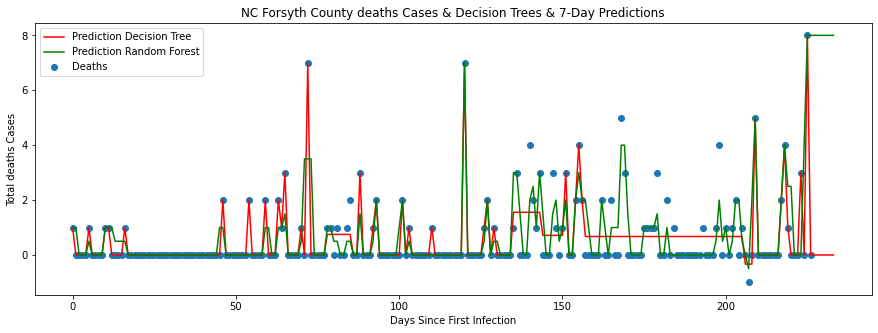

In [48]:
plt.figure(figsize=(15,5))

#Plot the current/real data as scatter plot
plt.scatter(NC_Forsyth_County_deaths["days_since_start"], NC_Forsyth_County_deaths["total"], label="Deaths" )

#Plot the Decision Tree for the next 7-days
plt.plot(nc_Forsyth_days_perdicted_deaths["days_since_start"],nc_Forsyth_days_perdicted_deaths["dec_tree_total"], label="Prediction Decision Tree", c="Red")

#Plot the Random Forest Tree for the next 7-days
plt.plot(rf_nc_Forsyth_days_perdicted_deaths["days_since_start"], rf_nc_Forsyth_days_perdicted_deaths["rf_total"], label="Prediction Random Forest", c="green")

plt.xlabel("Days Since First Infection")
plt.legend(loc="upper left")
plt.xlabel("Days Since First Infection")
plt.ylabel("Total deaths Cases")
plt.legend(loc="upper left")
plt.title("NC Forsyth County deaths Cases & Decision Trees & 7-Day Predictions")
plt.show()